In [125]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
#from torch.optim import Adam
#import torch.nn.functional as F
import math

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tslearn.metrics import SoftDTWLossPyTorch

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler
import seaborn as sns
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import silhouette_score

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.cluster

import os
import scipy

from sklearn.metrics import adjusted_rand_score
import random

In [143]:
class TransformerTimeSeriesModel(nn.Module):
    def __init__(self, input_dim, output_dim, seq_length, d_model, nhead, num_layers, dim_feedforward):
        super(TransformerTimeSeriesModel, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.seq_length = seq_length
 
        # Input Encoder (maps input to d_model size)
        self.encoder = nn.Linear(input_dim, d_model)  # (Batch, 3) -> (Batch, d_model)
        
        # Project input to match the sequence length
        self.expand_input = nn.Linear(d_model, seq_length * d_model)  # (Batch, d_model) -> (Batch, seq_length * d_model)
        
        # Target embedding for decoder input
        self.target_embedding = nn.Linear(1, d_model)  # New embedding layer for target sequence
  
        # Positional Encoding for Time Steps
        self.pos_encoder = PositionalEncoding(d_model, seq_length)
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Final Output Layer
        self.output_layer = nn.Linear(d_model, output_dim)  # (Batch, 255, d_model) -> (Batch, 255, 1)

    def forward(self, x, target_seq=None, inference=False):
        # Encode input features
        encoded_input = self.encoder(x)  # [Batch, d_model]
        if inference or target_seq is None:
            print(f"Encoded input shape: {encoded_input.shape}")
    
        expanded_input = self.expand_input(encoded_input).view(-1, self.seq_length, self.d_model)  # [Batch, seq_len, d_model]
        if inference or target_seq is None:
            print(f"Expanded input shape: {expanded_input.shape}")
    
        memory = self.pos_encoder(expanded_input)
        if inference or target_seq is None:
            print(f"Memory shape after positional encoding: {memory.shape}")
    
        if inference or target_seq is None:
            batch_size = x.size(0)
    
            # Transpose for transformer (S, B, D)
            memory = memory.transpose(0, 1)  # [seq_len, batch_size, d_model]
            print(f"Memory shape after transpose: {memory.shape}")
            
            # Start with <B, 1, 1> zero input
            generated = torch.zeros(batch_size, 1, 1).to(x.device)
            output_sequence = []
            
            for t in range(self.seq_length):
                tgt_emb = self.target_embedding(generated)  # [B, t+1, d_model]
                tgt_emb = self.pos_encoder(tgt_emb)
                tgt = tgt_emb.transpose(0, 1)  # [T, B, D] where T is target sequence length
                print(f"Target shape after positional encoding and transpose: {tgt.shape}")
                
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt.size(0)).to(x.device)
                print(f"Target mask shape: {tgt_mask.shape}")
                
                # Decode
                decoded = self.transformer_decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)
                print(f"Decoded shape: {decoded.shape}")
                
                prediction = self.output_layer(decoded[-1])  # [B, 1]
                print(f"Prediction shape before unsqueeze: {prediction.shape}")
                
                prediction = prediction.unsqueeze(1)  # [B, 1, 1]
                output_sequence.append(prediction)
                
                generated = torch.cat([generated, prediction], dim=1)
                print(f"Generated shape after concatenating prediction: {generated.shape}")
            
            return torch.cat(output_sequence, dim=1)  # [B, seq_len, 1]

                
        else:
            # Training mode (teacher forcing)
            target_embeddings = self.target_embedding(target_seq)  # [Batch, seq_length, d_model]
            target_embeddings = self.pos_encoder(target_embeddings)
    
            output = self.transformer_decoder(tgt=target_embeddings, memory=memory)
            predictions = self.output_layer(output)
            return predictions

In [127]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):  # give generous max_len
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

In [128]:
class TimeSeriesDataset(Dataset):
    def __init__(self, dataframe):
        self.X = torch.tensor(dataframe.iloc[:, :3].values, dtype=torch.float32)  # Input: [Batch, 3]
        self.Y = torch.tensor(dataframe.iloc[:, 3:].values, dtype=torch.float32).unsqueeze(-1) # Output: [Batch, 255, 1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [129]:
def train_model(model, dataloader, optimizer, loss_fn, num_epochs, device):
    loss_list = list()
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        for batch in dataloader:
            x, y = batch  # x: [Batch, N], y: [Batch, T]
            x, y = x.to(device), y.to(device)
            
            # Prepare target for teacher forcing
            target_seq = y 
            #target_seq = y[:, :-1]  # All except last time step
            #actual = y[:, 1:]       # All except first time step
            
            # Forward pass
            output = model(x, target_seq)
            loss = loss_fn(output, y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_list.append(loss.item())
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")
    return loss_list


In [130]:
def ts_cluster_visualization(y_pred, df, n_clusters, plot_title):
    ts_size = df.shape[1]
    ts_max = df.max()
    plt.figure()
    for cluster in range(n_clusters):
        plt.subplot(4, math.ceil(n_clusters/4), cluster+1)
        for ts in df[y_pred == cluster]:
            plt.plot(ts.ravel(), "k-", alpha=.2)
        plt.plot(np.mean(df[y_pred == cluster], axis=0), "r-")
        plt.xlim(0, ts_size)
        plt.ylim(0, ts_max)
        plt.text(0.55, 0.35,'Cluster %d' % (cluster),
                 transform=plt.gca().transAxes)
        if cluster == 1:
            plt.title(plot_title)      
    plt.tight_layout()
    plt.show()

# N=1000

## Train Model

In [144]:
##################################################################
# Set up      
##################################################################

print("Importing data...\n")

data_output = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_outputs_active.csv", header=None)
#print("Max value is :", data_output.to_numpy().max(), "\n")

scaler = MinMaxScaler()
#scaler.data_max_ = 1600
scaler.fit(data_output)
data_output = scaler.transform(data_output)
data_output = pd.DataFrame(data_output)

data_input = pd.read_csv("C:/Users/met48/Desktop/TS-Clustering/SimData/epsteinCV_inputs.csv", sep=" ", header=None)
data = pd.concat([data_input, data_output], axis=1)

data = data.sample(n=1000, random_state=1)

# Split the data into training and validation sets
train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# Save the validation set to a new CSV file
valid_data.to_csv("validation_set_epstein_n1000.csv", index=False)

##################################################################
# Model 1      
##################################################################

print("Starting model 1\n")

dataset = TimeSeriesDataset(train_data)

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

input_dim = 3      # Number of input features
output_dim = 1     # Predicting one value per time step
seq_length = 252   # Number of time steps in output
d_model = 128      # Embedding dimension for Transformer
nhead = 4          # Number of attention heads
num_layers = 2     # Number of Transformer layers
dim_feedforward = 512  # Feedforward network size

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeriesModel(
    input_dim, output_dim, seq_length, d_model, nhead, num_layers, dim_feedforward
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()  # Regression loss

# Training loop
num_epochs = 20  # Adjust based on dataset size and performance
loss = train_model(model, dataloader, optimizer, loss_fn, num_epochs, device)

df = pd.DataFrame(loss, columns=["loss"])
df.to_csv('transformer_adam_lr001_epstein_loss_n1000.csv', index=False)
torch.save(model.state_dict(), "transformer_adam_lr001_epstein_n1000.pth")

Importing data...

Starting model 1

Epoch 1/20, Loss: 0.03673592954874039
Epoch 2/20, Loss: 0.015749435871839523
Epoch 3/20, Loss: 0.004795354325324297
Epoch 4/20, Loss: 0.004252125043421984
Epoch 5/20, Loss: 0.0033288358245044947
Epoch 6/20, Loss: 0.0029321981128305197
Epoch 7/20, Loss: 0.0025566655676811934
Epoch 8/20, Loss: 0.001989952987059951
Epoch 9/20, Loss: 0.0018581083277240396
Epoch 10/20, Loss: 0.0014486792497336864
Epoch 11/20, Loss: 0.001567457104101777
Epoch 12/20, Loss: 0.0014908009907230735
Epoch 13/20, Loss: 0.0015951747773215175
Epoch 14/20, Loss: 0.0012940879678353667
Epoch 15/20, Loss: 0.0010949919233098626
Epoch 16/20, Loss: 0.0011730608530342579
Epoch 17/20, Loss: 0.0009980283211916685
Epoch 18/20, Loss: 0.0009649339481256902
Epoch 19/20, Loss: 0.0009536874713376164
Epoch 20/20, Loss: 0.0009098385344259441


## Import Model

In [141]:
input_dim = 3      # Number of input features
output_dim = 1     # Predicting one value per time step
seq_length = 252   # Number of time steps in output
d_model = 128      # Embedding dimension for Transformer
nhead = 4          # Number of attention heads
num_layers = 2     # Number of Transformer layers
dim_feedforward = 512  # Feedforward network size

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerTimeSeriesModel(
    input_dim, output_dim, seq_length, d_model, nhead, num_layers, dim_feedforward
).to(device)

checkpoint = torch.load('C:/Users/met48/Desktop/ABM-Surrogate/transformer_adam_lr001_epstein_n1000.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

## Evaluate model with validation inputs

In [132]:
data_val = pd.read_csv("C:/Users/met48/Desktop/ABM-Surrogate/validation_set_epstein_n1000.csv")
data_val = data_val.iloc[:, :3]  

In [142]:
model.eval()

with open('epsteinCV_gen_n1000.csv', 'w', newline='') as epsteinCV_inputs:
    for index, row in data_val.iterrows():
        # Prepare input: [cit_dens, cop_dens, leg]
        input_tensor = torch.tensor([[row[0], row[1], row[2]]], dtype=torch.float32).to(device)  # Shape: [1, 3]
        
        with torch.no_grad():`
            output = model(input_tensor, inference=True)  # Output: [1, 255, 1]

        print(f"Output shape: {output.shape}")
        flattened = output.view(-1).cpu().numpy()  # Flatten to [255]
        
        # Write to file
        print(*flattened, file=epsteinCV_inputs, sep=",")

C:\Users\met48\AppData\Local\Temp\ipykernel_16900\543831951.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  input_tensor = torch.tensor([[row[0], row[1], row[2]]], dtype=torch.float32).to(device)  # Shape: [1, 3]


Encoded input shape: torch.Size([1, 128])
Expanded input shape: torch.Size([1, 252, 128])
Memory shape after positional encoding: torch.Size([1, 252, 128])
Encoded input shape: torch.Size([1, 128])
Expanded input shape: torch.Size([1, 252, 128])
Memory shape after positional encoding: torch.Size([1, 252, 128])
Memory shape after transpose: torch.Size([252, 1, 128])
Target shape after positional encoding and transpose: torch.Size([1, 1, 128])
Target mask shape: torch.Size([1, 1])


RuntimeError: shape '[1, 4, 32]' is invalid for input of size 32256

## Visualize generated data

In [19]:
gen_data = pd.read_csv('epsteinCV_gen_n1000.csv', header=None)
data_val_ts = to_time_series_dataset(gen_data)
kmeans = TimeSeriesKMeans(n_clusters=10)
pred = kmeans.fit(data_val_ts)
ts_cluster_visualization(pred.labels_, data_val_ts, 10, "Epstein Validation Generated N=1000")

EmptyDataError: No columns to parse from file

## Visualize validation data

In [20]:
data_val = pd.read_csv("C:/Users/met48/Desktop/ABM-Surrogate/validation_set_epstein_n1000.csv")
data_val = data_val.iloc[:, 3:]  

C:\Users\met48\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


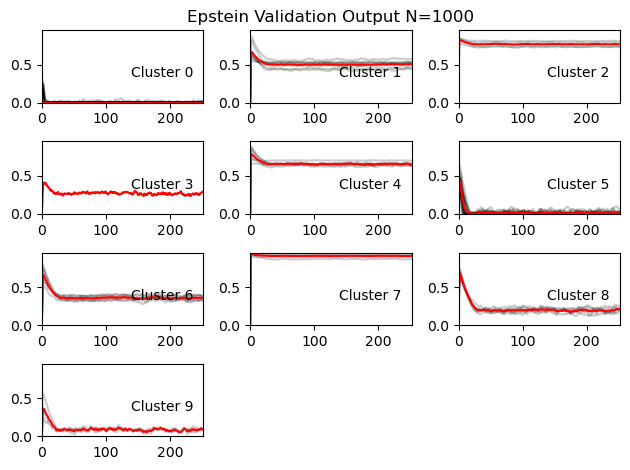

In [21]:
data_val_ts = to_time_series_dataset(data_val)
kmeans = TimeSeriesKMeans(n_clusters=10)
pred = kmeans.fit(data_val_ts)
ts_cluster_visualization(pred.labels_, data_val_ts, 10, "Epstein Validation Output N=1000")

# N = 5000